In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
# Merge our DFT result data with the Kraken ML data for the ligands.
dft_df = pd.read_csv("dft_data/grand_lambda_max_data.csv")
kraken_df = pd.read_csv("kraken_data/ml_8_210.csv")

merged_df = pd.merge(dft_df, kraken_df, on="molecule_id")
merged_df.head()
# Effectively, I think of this as a left joining kraken_df on dft_df

,molecule_id,lambda_max,shift,smiles,dipolemoment_max,pyr_P_max,pyr_alpha_max,qpole_amp_max,qpoletens_xx_max,qpoletens_yy_max,...,vbur_qvbur_max_boltzmann_average,vbur_qvbur_min_boltzmann_average,vbur_qvtot_max_boltzmann_average,vbur_qvtot_min_boltzmann_average,vbur_ratio_vbur_vtot_boltzmann_average,vbur_vbur_boltzmann_average,vbur_vtot_boltzmann_average,vmin_r_boltzmann_average,vmin_vmin_boltzmann_average,volume_boltzmann_average
0,8,395.4,0.0,CC(C)(C)P(C(C)(C)C)C(C)(C)C,0.785410,0.814829,32.633045,2.286466,1.155208,0.415022,...,20.849024,14.705131,92.370575,50.689070,0.277816,72.062120,253.71219,1.756687,-0.069888,320.95413
1,12,421.5,26.1,CC(C)(C)CP(C(C)(C)C)C(C)(C)C,0.819760,0.883014,28.707630,1.997507,0.856250,0.404486,...,21.402498,14.062596,89.652150,54.039700,0.271465,74.782196,271.61676,1.767097,-0.064135,345.01490
2,1136,342.5,-52.9,COc1ccccc1P(C(C)(C)C)C(C)(C)C,2.237652,0.850125,30.491308,8.078578,5.090006,-0.255614,...,24.715187,14.204321,121.041610,51.253967,0.250615,72.552680,298.06810,1.786581,-0.070114,360.76010
3,1648,378.0,-17.4,CC(C)(C)P(c1cccc2ccccc12)C(C)(C)C,0.943379,0.852600,30.313591,5.221972,3.356086,0.202083,...,27.215685,14.099444,146.207050,46.511883,0.235295,75.336480,322.30103,1.779128,-0.060278,385.63310
4,1656,414.7,19.3,Cc1cc(C)c(P(C(C)(C)C)C(C)(C)C)c(C)c1,1.063524,0.785253,33.952614,4.349228,2.703184,-0.062903,...,27.946302,15.067517,128.196730,51.288940,0.252914,80.446860,320.88870,1.754941,-0.062705,392.55540


In [3]:
# Exploration:
# plt.figure(figsize= (100, 100))
# corr_heatmap = sns.heatmap(merged_df.iloc[:, 4:].corr(), annot=True)
# fig = corr_heatmap.get_figure()
# fig.savefig("predictor_corr_heatmap.png")

# Clearly we have too many features and a lot of multicollinearity.

In [4]:
# Let's start with the top 20 features in the first principal component from our PCA (see ligand_pca.ipynb)
# Then let's examine their multicollinearity and remove features until we have significantly reduced that.
# We can also use various algorithms to do feature selection for us at this point.
first_pca_20 = [
    "nbo_lp_P_percent_s_boltzmann_average",
    "nbo_lp_P_occ_boltzmann_average",
    "nmrtens_sxx_P_boltzmann_average",
    "vmin_r_boltzmann_average",
    "nmr_P_boltzmann_average",
    "vbur_max_delta_qvtot_max",
    "vbur_max_delta_qvtot_vburminconf",
    "vbur_ratio_vbur_vtot_boltzmann_average",
    "vbur_max_delta_qvtot_boltzmann_average",
    "vbur_max_delta_qvtot_min",
    "sterimol_burB5_boltzmann_average",
    "vbur_ovbur_max_max",
    "vbur_qvbur_max_max",
    "vbur_ovbur_max_vburminconf",
    "vbur_ovbur_max_boltzmann_average",
    "vbur_qvbur_max_boltzmann_average",
    "vbur_ovbur_max_min",
    "vbur_qvbur_max_min",
    "vbur_far_vtot_max"
]
features = merged_df[first_pca_20]

# plt.figure(figsize= (20, 20))
# corr_heatmap = sns.heatmap(features.corr(), annot=True)

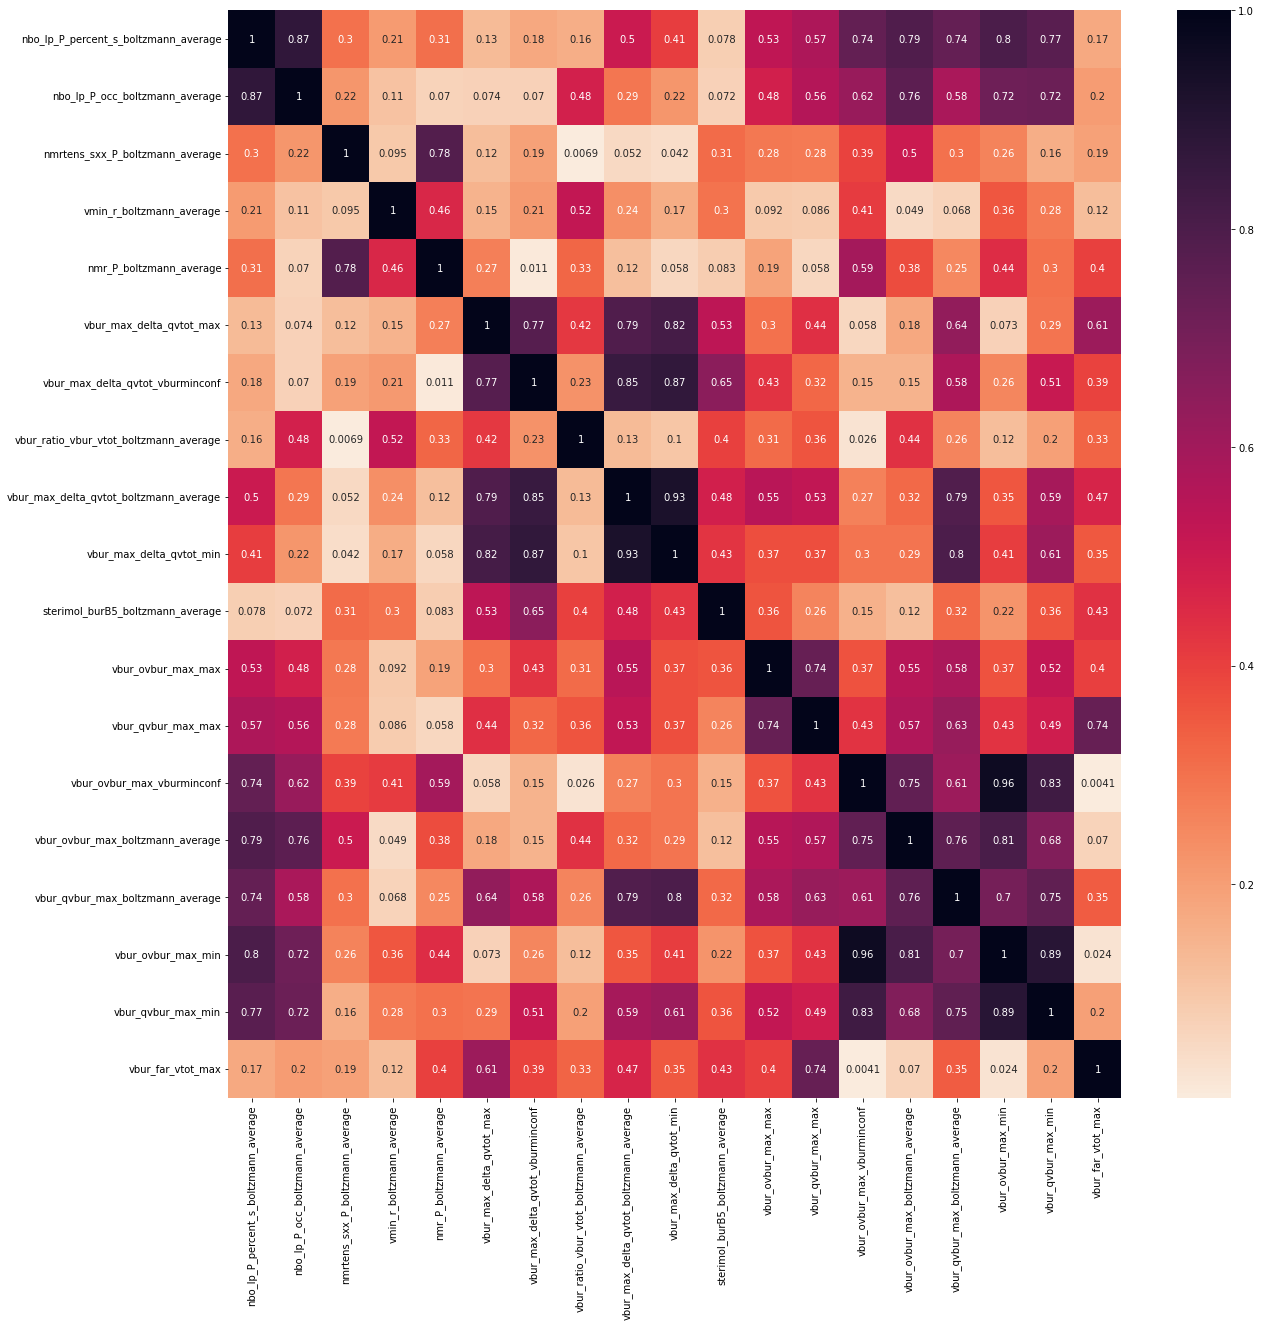

In [5]:
# Let's do an absolute heatmap (and set the color axis so that 0 is light, 1 is dark):
plt.figure(figsize= (20, 20))
cmap = sns.cm.rocket_r
abs_corr_heatmap = sns.heatmap(abs(features.corr()), annot=True, cmap=cmap)

In [6]:
# Set the feature and target values:
X = features.values
target = merged_df.columns[1]
y = merged_df[target].values

In [7]:
# Lasso CV: should be good since we need to do feature selection/regularization, but I'm not sure if it does that well if we already have significant multicollinearity

lasso_cv = LassoCV(alphas=[6, 10, 15], tol=0.001, random_state=0).fit(X, y)
# lasso_cv = LassoCV(alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10], random_state=0).fit(X, y)
print(f"Lasso model training score: {lasso_cv.score(X, y)}")

# Note: it always seems to select the model with the highest alpha...

Lasso model training score: 0.4538174450119249


<Axes: >

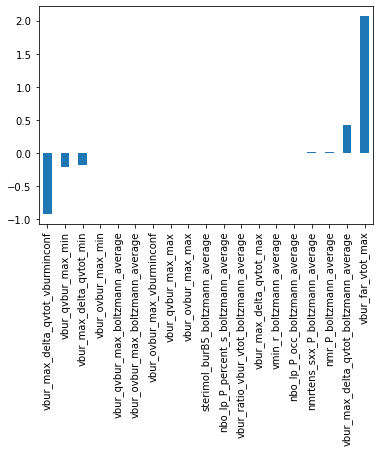

In [8]:
pd.Series(lasso_cv.coef_, first_pca_20).sort_values(ascending = True).plot(kind = "bar")

In [9]:
# Elastic Net
# This model combines the L1 penalty of the Lasso with the L2 penalty of Ridge Regression
# This model should be good for us. It handles high-dimensional data like the Lasso, while also handling multicollinearity like Ridge Regression, both problems we have.

# Arbitrary example:
elastic_net = ElasticNet(alpha=0.5, l1_ratio=0.7)
elastic_net.fit(X, y)
print(f"Elastic Net model training score: {elastic_net.score(X, y)}")

Elastic Net model training score: 0.6821549900769442


In [10]:
# pd.Series(elastic_net.coef_, first_pca_20).sort_values(ascending = True).plot(kind = "bar")

In [11]:
print(sklearn.metrics.get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'd2_absolute_error_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'neg_root_mean_squared_log_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'r

In [12]:
# We really need to do some hyperparameter tuning when it comes to alpha and l1_ratio. 
# Let's do a Grid Search CV
# Seems like I'd have to use Cp or some information criterion as the scoring metric?
# Those don't seem to be available. TODO: address scoring metric choice

elastic_net_gs = ElasticNet(tol=0.0001, max_iter=1000000)

search_space = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "l1_ratio": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}

gs_elastic_net = GridSearchCV(
    estimator=elastic_net_gs,
    param_grid=search_space,
    scoring=["r2", "neg_mean_absolute_error"],
    refit="r2",
    cv=5
)

In [13]:
gs_elastic_net.fit(X, y)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=1000000),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9]},
             refit='r2', scoring=['r2', 'neg_mean_absolute_error'])

In [14]:
print(f"Grid Search Elastic Net model training score: {gs_elastic_net.score(X, y)}")

Grid Search Elastic Net model training score: 0.48408570479538904


<Axes: >

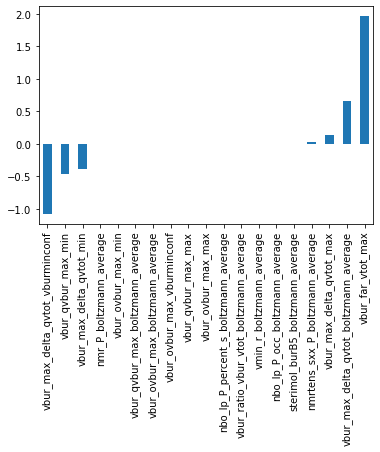

In [15]:
pd.Series(gs_elastic_net.best_estimator_.coef_, first_pca_20).sort_values(ascending = True).plot(kind = "bar")

In [16]:
# Forward stepwise selection
sfs_lasso = SequentialFeatureSelector(
    Lasso(alpha=10, tol=0.0001, max_iter=1000000),  # or some other model?
    n_features_to_select=4,
    scoring='neg_mean_absolute_error',
    direction='forward',
    cv=5
)

In [17]:
sfs_lasso.fit(X, y)

SequentialFeatureSelector(estimator=Lasso(alpha=10, max_iter=1000000),
                          n_features_to_select=4,
                          scoring='neg_mean_absolute_error')

In [18]:
for i, mask_val in enumerate(sfs_lasso.get_support()):
    if mask_val:
        print(first_pca_20[i])

nbo_lp_P_occ_boltzmann_average
vmin_r_boltzmann_average
vbur_ovbur_max_min
vbur_far_vtot_max


In [19]:
sfs_lasso.estimator_

AttributeError: 'SequentialFeatureSelector' object has no attribute 'estimator_'

In [ ]:
# Ok, how do I check out the model in there??

print(f"Grid Search Elastic Net model training score: {sfs_lasso.estimator_.score(X, y)}")